# Compare Usage of Bike Share Program Among Users

#### Statistical Inference study on Weather Conditions Collected from a Bike Sharing Service

##### Authors: Alex Bastin, Amy Zhong, Naaimur Reza & Jeffrey Gao

<img src="https://gohopr.com/wp-content/uploads/banner.jpg" alt="Alternative text" width = "600"/>

## Introduction

Bike sharing systems are a novel method of public transportation that allows users to independently and autonomously rent, use, and return bikes to serve their daily transportation needs. Self-contained bike rental stations that are scattered across cities dispense bikes once users validate themselves or pay with an automated kiosk. These bikes are often equipped with an array of sensors, enabling them to collect an abundance of user usage data including weather data, like temperature and humidity; timing data, like day and time; and user data, like count of casual user daily usage (Fanaee-T & Gama, 2013). This data can be amalgamated into datasets to be analyzed by various interested parties, like the bike-sharing company or the city hosting the bike-sharing program. The dataset identified in this study is from a two-year study of the Capital Bikeshare system program in Washington, D.C. during 2011 and 2012 (Fanaee-T & Gama, 2013). The dataset contains 731 days of data wherein each day has 17 variables. These variables include the aforementioned data; weather data, timing data, and usage data.

The objective of this analysis is to determine if the proportion of “registered” users of the Capital Bikeshare program is higher during the work week than “casual” users to a degree of statistical significance. We hope to derive further conclusions as we partition the dataset into winter and summer usage data, creating separate two datasets to analyze. We will quantify this usage with proportion mean as a location parameter and standard deviation as the scale parameter. We examine these two datasets with bootstrapping and asymptotic methods to derive summary statistics for each.

For our analysis, two academic studies are deemed relevant. Kim (2018) analyzed a dataset of registered and non-registered user usage of a bike-sharing program usage in Daejeon, Korea. They found that demand for bike rental usage is significantly more inelastic to heat on working days than non-working days. The study also found that registered users are less inelastic to weather effects across all the data. Kim (2018) suggests explanations for the behaviors of registered users, such the registered users being commuters that rely on the service to commute between their home and work. Hosford (2018) analyzed a similar dataset of the Vancouver bike-sharing program, Mobi by Shaw that surveyed the program’s usage at varying intervals after its implementation. Contrary to Kim (2018), they found that the implementation of a bike share program has little impact on increasing bikeshare program usage rates both among registered and casual users in the long-term. Hosford (2018) did observe a significant increase in usage near the beginning of the implementation and proposes this is caused by the novelty of the program, which wanes in the long-run.

## Method: Preliminary Analysis

First, we will load required packages.

In [34]:
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(dplyr)
library(broom)
library(datateachr)
require(gridExtra)

Next, we load data from the original source on the web and unzip the file.

In [39]:
# URL
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

# Download the dataset from the web
destfile <- "data/localfile.zip"
download.file(url, destfile)

# Unzip the file
unzip("data/localfile.zip", exdir = "data/")          


Now, we clean and wrangle the data into a tidy format. The wrangling involves changing the "season" and "workingday" variables into factors, and mutating an additional columnn as the proportion of users that are registered for the given observation (day) in the dataset. We also convert the numeric representations of seasons outlined in the dataset read.me (1 = winter, 2 = spring, 3 = summer, 4 = fall) into factors as strings.

In [160]:
# Convert from csv to a dataframe
weather_data <- read.csv("data/day.csv")

# Factorizing
weather_data$workingday <- as_factor(weather_data$workingday)
weather_data$season <- as_factor(weather_data$season)

# Converting factors from int to string form
levels(weather_data$season) <- c("Winter","Spring","Summer","Fall")
levels(weather_data$workingday) <- c("no","yes")

# Mutating proportion column
weather_mutated_data <- weather_data %>% mutate(prop = registered/cnt)

head(weather_mutated_data)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,prop
,<int>,<chr>,<fct>,<int>,<int>,<int>,<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>
1,1,2011-01-01,Winter,0,1,0,6,no,2,0.344167,0.363625,0.805833,0.1604460,331,654,985,0.6639594
2,2,2011-01-02,Winter,0,1,0,0,no,2,0.363478,0.353739,0.696087,0.2485390,131,670,801,0.8364544
3,3,2011-01-03,Winter,0,1,0,1,yes,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349,0.9110452
4,4,2011-01-04,Winter,0,1,0,2,yes,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562,0.9308579
5,5,2011-01-05,Winter,0,1,0,3,yes,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600,0.9487500
6,6,2011-01-06,Winter,0,1,0,4,yes,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606,0.9452055


We then filter the datasets to include only relevant data, and partition the datasets into summer and winter datasets. 

In [111]:
## Filter and select the data in winter
registered_prop_winter <-
    weather_mutated_data %>%
    filter(season == "Winter") %>%
    select(workingday, prop, season)

head(registered_prop_winter)

## Filter and select the data in summer
registered_prop_summer <-
    weather_mutated_data %>%
    filter(season == "Summer") %>%
    select(workingday, prop, season)

head(registered_prop_summer)

,workingday,prop,season
,<fct>,<dbl>,<fct>
1,no,0.6639594,Winter
2,no,0.8364544,Winter
3,yes,0.9110452,Winter
4,yes,0.9308579,Winter
5,yes,0.9487500,Winter
6,yes,0.9452055,Winter


,workingday,prop,season
,<fct>,<dbl>,<fct>
1,yes,0.8399173,Summer
2,yes,0.8533393,Summer
3,yes,0.8442589,Summer
4,yes,0.8058505,Summer
5,no,0.6574394,Summer
6,no,0.6380773,Summer


We then collect location and scale parameters for each dataset to use for the asymptotic analysis below. We use pivot_wider to make the values more accessible.

In [112]:
# Summary parameter for summer
sample_summary_summer <-
    registered_prop_summer %>%
    group_by(workingday) %>%
    summarize(mean = mean(prop),
              n = n(),
              sd = sd(prop),
              `.groups` = "drop") %>%
    pivot_wider(names_from = workingday, values_from = c(n, sd, mean)) %>% 
    mutate(mean_diff = mean_yes - mean_no)

# Summary parameter for winter
sample_summary_winter <-
    registered_prop_winter %>%
    group_by(workingday) %>%
    summarize(mean = mean(prop),
              n = n(),
              sd = sd(prop),
              `.groups` = "drop") %>%
    pivot_wider(names_from = workingday, values_from = c(n, sd, mean)) %>% 
    mutate(mean_diff = mean_yes - mean_no)

sample_summary_winter
sample_summary_summer

n_no,n_yes,sd_no,sd_yes,mean_no,mean_yes,mean_diff
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
61,120,0.1083181,0.04706721,0.7871169,0.9219079,0.134791


n_no,n_yes,sd_no,sd_yes,mean_no,mean_yes,mean_diff
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
57,131,0.05919498,0.02988689,0.6578987,0.8421875,0.1842887


We finally plot registered and non-registered user usage proportions with two boxplots to visualize any differences between the groups.

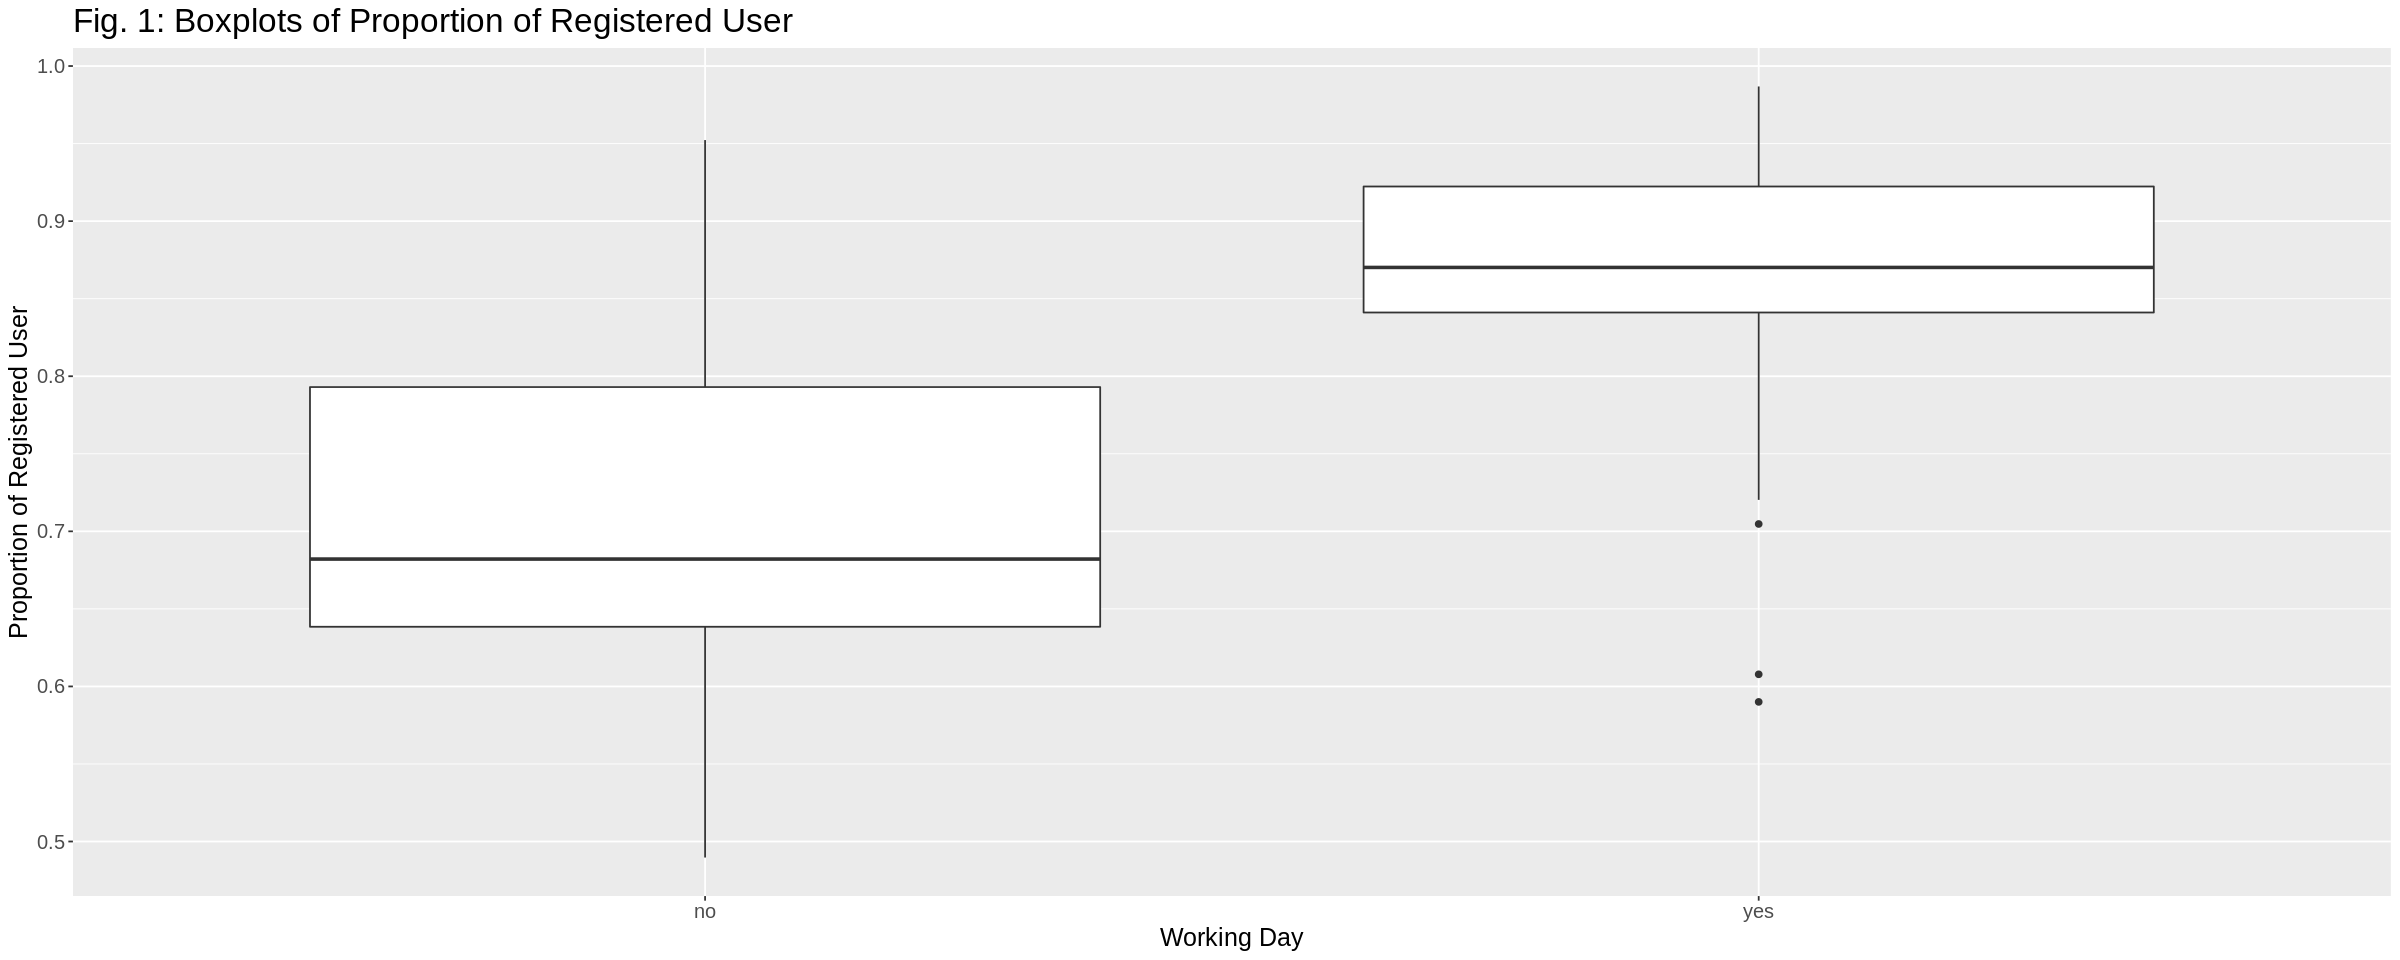

In [153]:
# Setting the scale
options(repr.plot.width = 20, repr.plot.height = 8)

# Creating the two boxplots
boxplots <- 
    weather_mutated_data %>%  
    ggplot(aes(x = workingday, y = prop)) + 
    geom_boxplot() + 
    xlab("Working Day") +
    ylab("Proportion of Registered User") +
ggtitle("Fig. 1: Boxplots of Proportion of Registered User")+
theme(plot.title = element_text(size = 20), axis.title=element_text(size=15), text = element_text(size=15))

boxplots

## Methods: Hypothesis Testing, Asymptotics, and Confidence Intervals

### Hypothesis Testing

We conduct the hypothesis test for both seasons simulatenously for simplicity and to better understand differences. For the test statistic, we only use specify() and calculate().

In [163]:
## Calculate the test statistics
test_stat_winter <-
    registered_prop_winter %>%
    specify(formula = prop ~ workingday) %>%
    calculate(stat = "diff in means", order = c("yes", "no")) 

test_stat_summer <-
    registered_prop_summer %>%
    specify(formula = prop ~ workingday) %>%
    calculate(stat = "diff in means", order = c("yes", "no"))

test_stat_winter
test_stat_summer

stat
<dbl>
0.134791


stat
<dbl>
0.1842887


We then set the seed as 100 and build the null model using specify(), hypothesize(), generate(), and calculate(). We set reps to 1000 to generate 1000 replicates or samples.

In [115]:
## Setting the seed
set.seed(100)

## Creating the null model for the winter dataset
null_model_winter <-
    registered_prop_winter %>%
    specify(formula = prop ~ workingday) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("yes", "no"))

## Creating the null model for the summer dataset
null_model_summer <-
    registered_prop_summer %>%
    specify(formula = prop ~ workingday) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("yes", "no"))

head(null_model_summer)
head(null_model_winter)

replicate,stat
<int>,<dbl>
1,0.002491569
2,0.005633204
3,-0.012072301
4,0.010255962
5,0.028834272
6,0.008587466


replicate,stat
<int>,<dbl>
1,0.011273418
2,-0.007836771
3,-0.004336829
4,-0.020817791
5,0.010187444
6,-0.003194765


With the null model and test statistics for both summer and winter, we can calculate the P-value for each using get_p_value(). We set the direction to two-sided as our alternate hypothesis does not specify direction ("higher than", "lower than") and only seeks difference. 

In [116]:
## Calculating the 
p_value_winter <- 
    null_model_winter %>%
    get_p_value(obs_stat = test_stat_winter, direction = "two_sided")

p_value_summer <- 
    null_model_summer %>%
    get_p_value(obs_stat = test_stat_summer, direction = "two_sided")

p_value_winter
p_value_summer

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”
Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


p_value
<dbl>
0


We then find both p-values to equal 0 indicating statistical significance at every possible significant level.

We then plot the null model and p-value for both the winter and summer datasets using visualize() and shade_p_value().

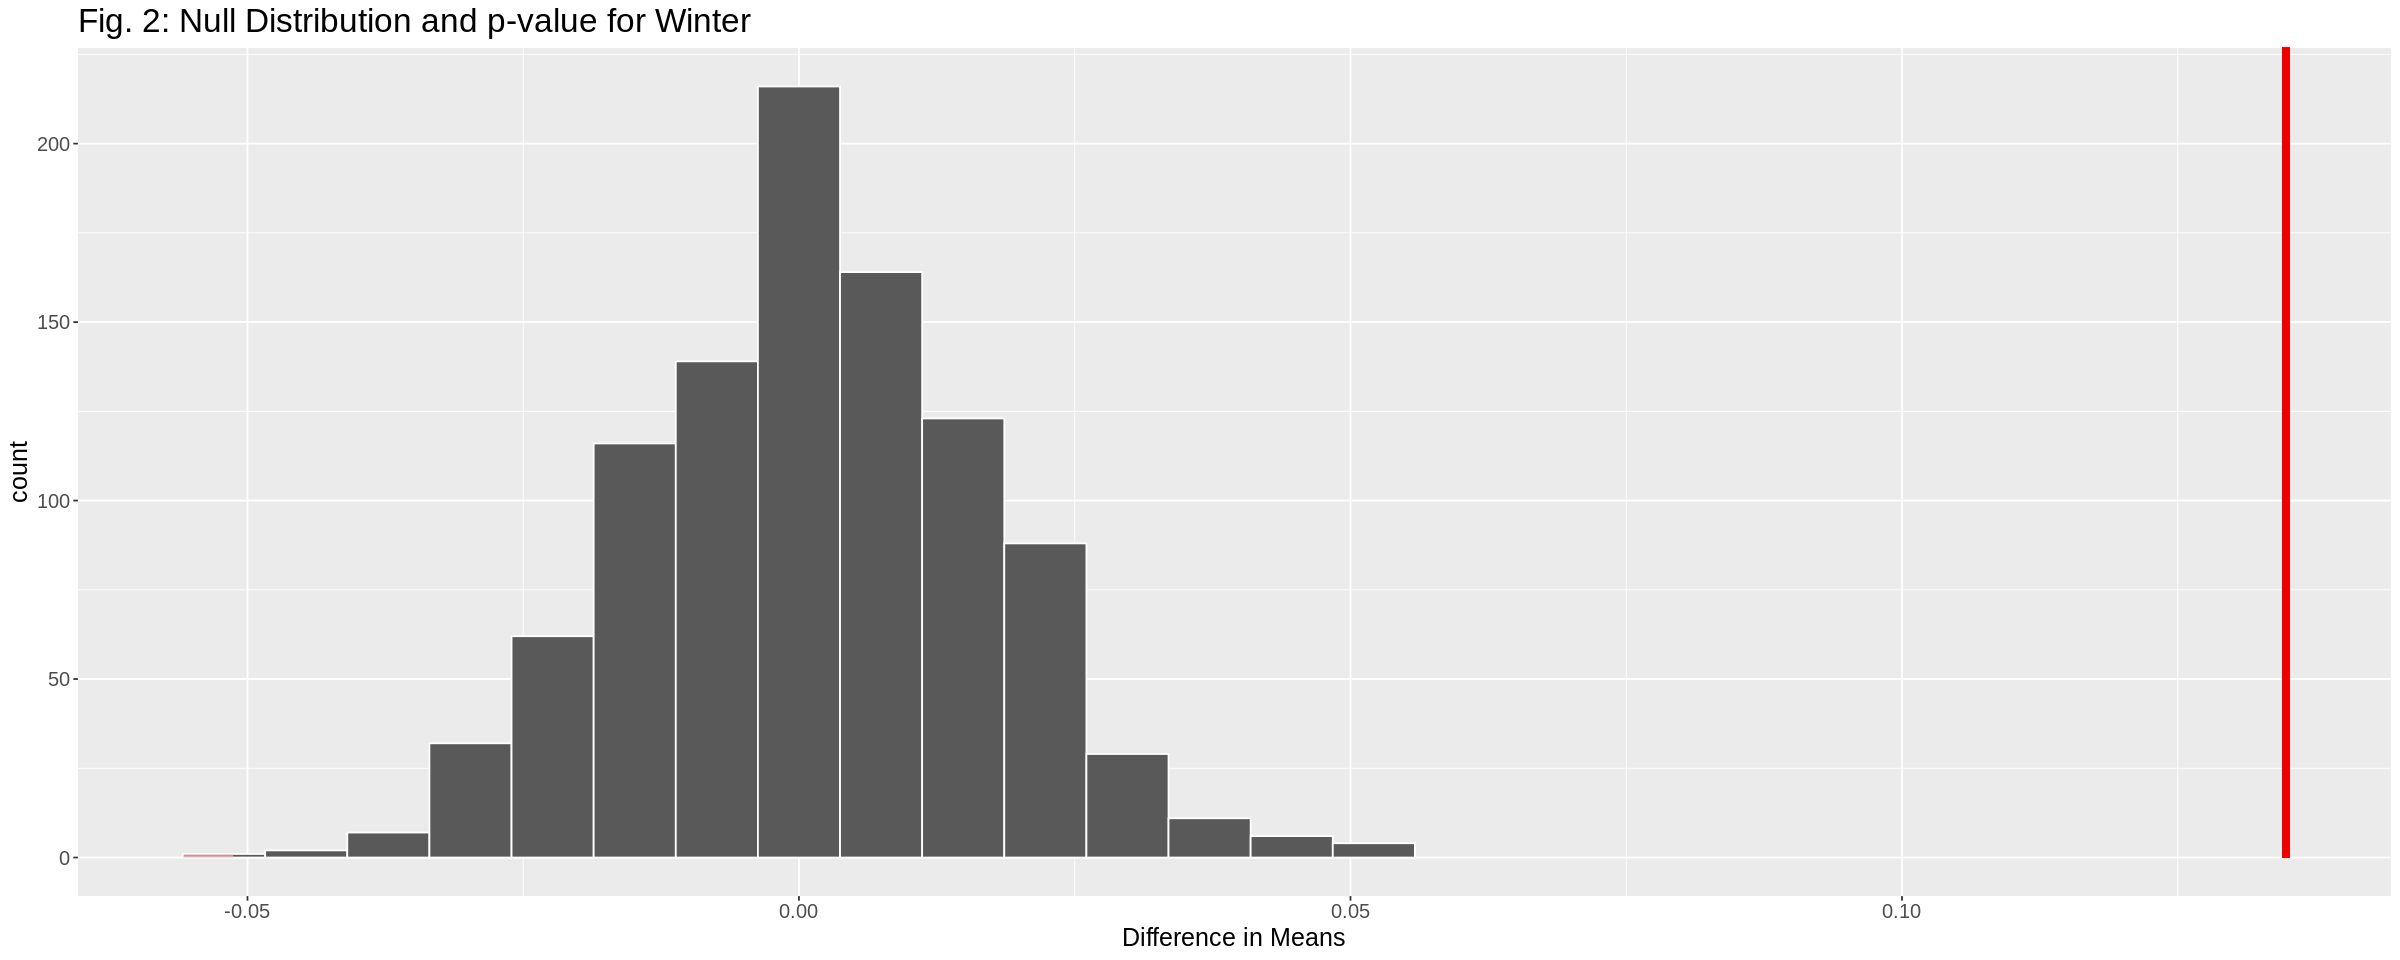

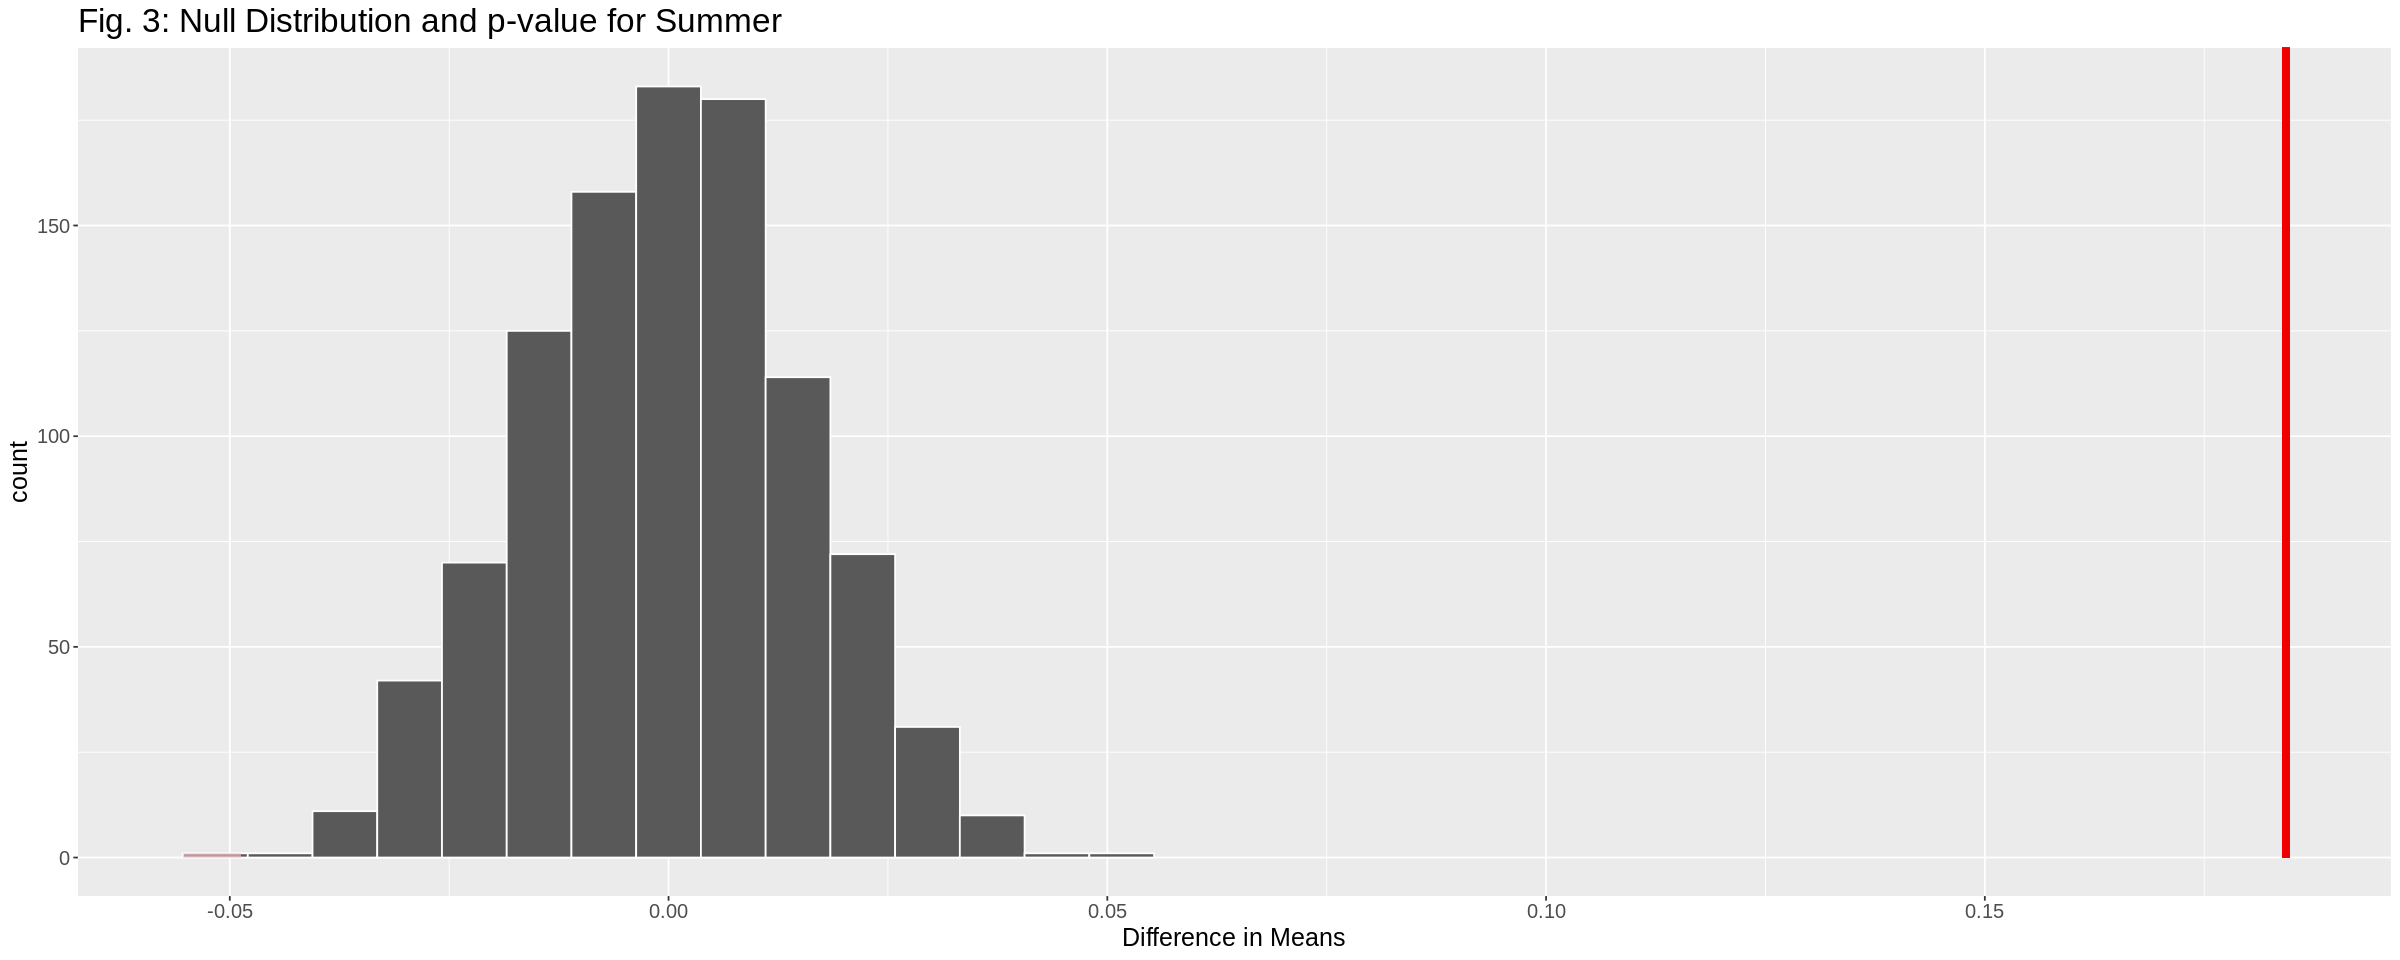

In [154]:
## Visualizing the winter dataset
registered_plot_winter <-
    null_model_winter %>%
    visualize() +
    shade_p_value(obs_stat = test_stat_winter, direction = "two_sided") +
    labs(x = "Difference in Means") +
    ggtitle("Fig. 2: Null Distribution and p-value for Winter") + 
    theme(plot.title = element_text(size = 20), axis.title=element_text(size=15), text = element_text(size=15))

## Visualizing the summer dataset
registered_plot_summer <-
    null_model_summer %>%
    visualize() +
    shade_p_value(obs_stat = test_stat_summer, direction = "two_sided") +
    labs(x = "Difference in Means") +
    ggtitle("Fig. 3: Null Distribution and p-value for Summer") + 
    theme(plot.title = element_text(size = 20), axis.title=element_text(size=15), text = element_text(size=15))

registered_plot_winter
registered_plot_summer

### Asymptotics

For the asymptotic approach, we need to use the t-distribution. Therefore, we also need to check the assumptions for t-distribution and ensure they are met for both summer and winter datasets. 

1. <b>The population is normally distributed</b>: We do not have full access to the population, so we cannot assume the population is normally distributed.
2. <b>The population is not normally distributed</b>: We need to check if the Central Limit Theorem is valid here. Both datasets are large enough that each of them exceed size 50.

With the assumptions met for both datasets, we mutate the summary parameters found in the preliminary analysis to include the difference between means and standard error of the null model. 

In [118]:
## calculate the test statistics
sample_summary_winter <-
    sample_summary_winter %>%
    mutate(mean_diff = mean_yes - mean_no) %>%
    mutate(null_std_error = sqrt(sd_yes^2/n_yes + sd_no^2/n_no)) %>%
    mutate(test_stat = mean_diff/null_std_error)

sample_summary_summer <-
    sample_summary_summer %>%
    mutate(mean_diff = mean_yes - mean_no) %>%
    mutate(null_std_error = sqrt(sd_yes^2/n_yes + sd_no^2/n_no)) %>%
    mutate(test_stat = mean_diff/null_std_error)

sample_summary_winter
sample_summary_summer

n_no,n_yes,sd_no,sd_yes,mean_no,mean_yes,mean_diff,null_std_error,test_stat
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
61,120,0.1083181,0.04706721,0.7871169,0.9219079,0.134791,0.01451902,9.283751


n_no,n_yes,sd_no,sd_yes,mean_no,mean_yes,mean_diff,null_std_error,test_stat
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
57,131,0.05919498,0.02988689,0.6578987,0.8421875,0.1842887,0.008263959,22.3003


We then calculate the p-value of the difference in means for winter and summer datasets and use mutate() to add it to the existing summary tibble.

In [122]:
## calculate the p-value
sample_summary_winter <- sample_summary_winter %>%
    mutate(p_value = 2 * pt(test_stat, df = nrow(registered_prop_winter) - 1, lower.tail = FALSE))

sample_summary_summer <- sample_summary_summer %>%
    mutate(p_value = 2 * pt(test_stat, df = nrow(registered_prop_summer) - 1, lower.tail = FALSE))

sample_summary_winter
sample_summary_summer

n_no,n_yes,sd_no,sd_yes,mean_no,mean_yes,mean_diff,null_std_error,test_stat,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
61,120,0.1083181,0.04706721,0.7871169,0.9219079,0.134791,0.01451902,9.283751,5.263569e-17


n_no,n_yes,sd_no,sd_yes,mean_no,mean_yes,mean_diff,null_std_error,test_stat,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
57,131,0.05919498,0.02988689,0.6578987,0.8421875,0.1842887,0.008263959,22.3003,1.429994e-54


We then filter the summer and winter datasets into working and non-working groups for which we use in the t.test() function. We also use tidy() to keep everything organized.

In [132]:
## perform the t-test
working_winter <- filter(registered_prop_winter, workingday == "yes")
nonworking_winter <- filter(registered_prop_winter, workingday == "no")
registered_t_test_winter <- tidy(t.test(x = working_winter$prop, y = nonworking_winter$prop, alternative = "two.sided"))
registered_t_test_winter

working_summer <- filter(registered_prop_summer, workingday == "yes")
nonworking_summer <- filter(registered_prop_summer, workingday == "no")
registered_t_test_summer <- tidy(t.test(x = working_summer$prop, y = nonworking_summer$prop, alternative = "two.sided"))
registered_t_test_summer

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.134791,0.9219079,0.7871169,9.283751,6.409996e-14,71.73721,0.105846,0.163736,Welch Two Sample t-test,two.sided


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.1842887,0.8421875,0.6578987,22.3003,3.439724e-33,68.74723,0.1678015,0.200776,Welch Two Sample t-test,two.sided


Using the tibbles above, we see that at every conventional significance level (0.05, 0.01, 0.001) the difference in means remains statistically significant.

### Bootstrapping

In our final approach, we use a bootstrap distribution to find the sample mean difference and its confidence interval.

In [144]:
## Creating a bootstrap distribution for the winter dataset
resampled_winter <-
    registered_prop_winter %>%
    specify(response = prop) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "mean")
head(resampled_winter)

## Creating a bootstrap distribution for the summer dataset
resampled_summer <-
    registered_prop_summer %>%
    specify(response = prop) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "mean")
head(resampled_summer)

replicate,stat
<int>,<dbl>
1,0.8914715
2,0.8783267
3,0.8807860
4,0.8686965
5,0.8781969
6,0.8808400


replicate,stat
<int>,<dbl>
1,0.7900478
2,0.7903428
3,0.7742790
4,0.7758747
5,0.7933497
6,0.7687650


With both distributions now available, we use get_confidence_interval() and specify our desired confidence level (95%) to find the distributions confidence interval.

In [151]:
## Calculating the 95% confidence interval for both winter and summer distributions
percentile_ci_winter <- get_confidence_interval(resampled_winter, level = 0.95, type ="percentile")
percentile_ci_summer <- get_confidence_interval(resampled_summer, level = 0.95, type ="percentile")

percentile_ci_winter
percentile_ci_summer

lower_ci,upper_ci
<dbl>,<dbl>
0.8628526,0.8901946


lower_ci,upper_ci
<dbl>,<dbl>
0.7732154,0.7989117


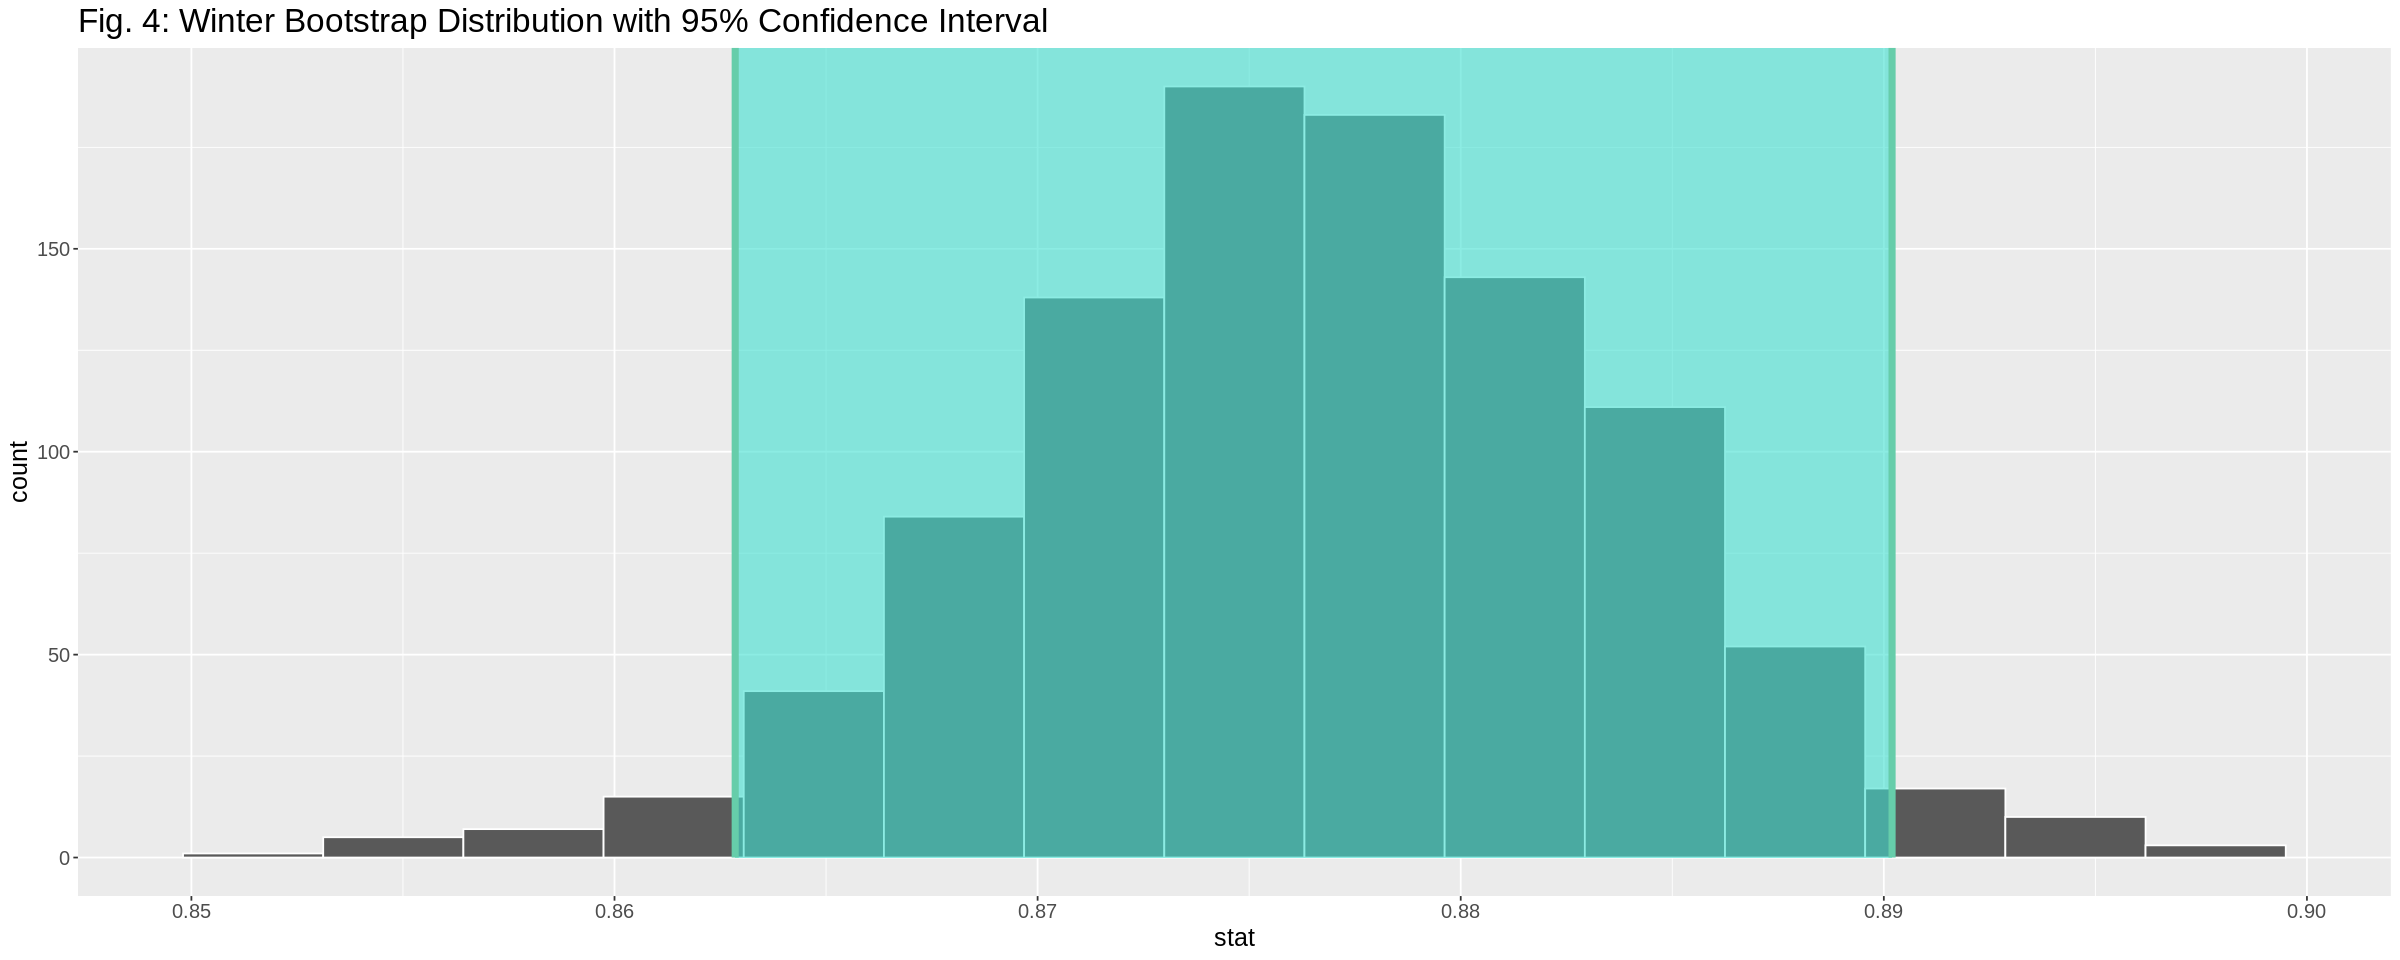

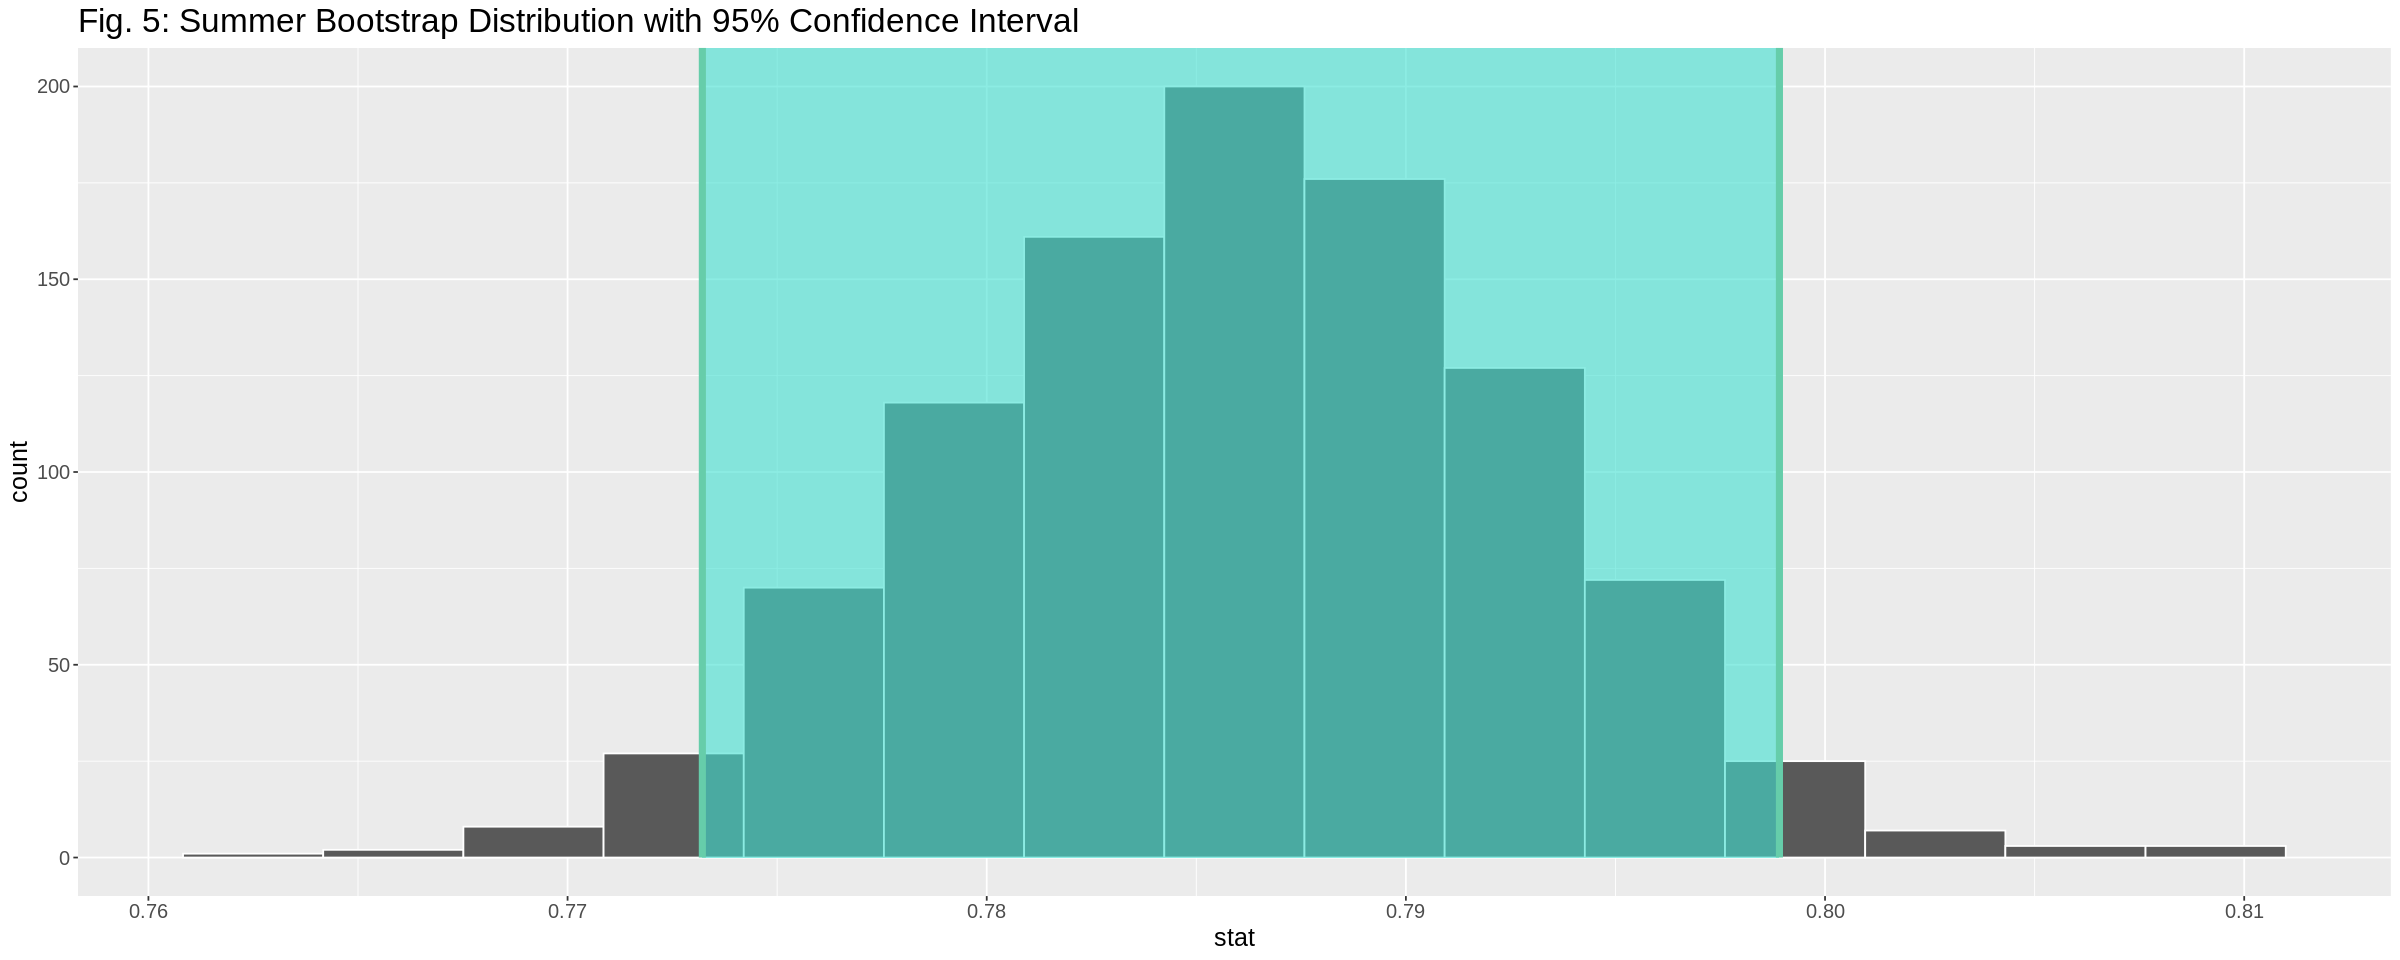

In [159]:
## Visualizing the winter distributions with its confidence intervals overlain
winter_ci_visualized <- visualize(resampled_winter) +    
    shade_confidence_interval(endpoints = percentile_ci_winter) + 
    ggtitle("Fig. 4: Winter Bootstrap Distribution with 95% Confidence Interval") + 
    theme(plot.title = element_text(size = 20), axis.title=element_text(size=15), text = element_text(size=15))

## Visualizing the summer distributions with its confidence intervals overlain
summer_ci_visualized <- visualize(resampled_summer) +    
    shade_confidence_interval(endpoints = percentile_ci_summer) + 
    ggtitle("Fig. 5: Summer Bootstrap Distribution with 95% Confidence Interval") +
    theme(plot.title = element_text(size = 20), axis.title=element_text(size=15), text = element_text(size=15))

winter_ci_visualized
summer_ci_visualized

With the confidence intervals better understood through their visualization over the distribution, we can easily interpret them with conclusive statements. These are that; 

We are 95% confident that the true value of the mean proportions of registered users during the winter is between 0.8618008 and 0.8895404;

We are 95% confident that the true value of the mean proportions of registered users during the summer is between 0.7725455 and 0.7987492.

## Discussion

For our analysis, we find the following hypotheses to benchmark our analysis

H<sub>0</sub>: the proportion of registered riders during workdays is equivalent to non-working days across both summer and winter
H<sub>A</sub> : the proportion of registered riders during the workdays is not equivalent to non-working days during either summer or winter

DISCUSS FINDINGS HERE --> Contextualize data

- Summarize what you found, and the implications/impact of your findings.
- If relevant, discuss whether your results were what you expected to find.
- Discuss future questions/research this study could lead to.

Bootstrapping is simulation-based inference. It is easier to understand than the asymptotic method. Bootstrapping is useful when there is no theory that could describe the distribution of the data. However, if the sample is not a representative one, bootstrapping can give a very off result since it does not correct the bias. On the other hand, asymptotic method tells us what the sampling distribution should look like, but there are a few assumptions to be meet. Both bootstrapping and asymptotic method work for the data set we explored in our project. As mentioned above, the assumptions for using the t-distribution are met here. Bootstrapping and asymptotic method generally produce similar results, and our study is no different. Our bootstrapping approach found a p-value of 0 for both summer and winter proportions and the asymptotic method found practically-zero p-values. Both p-values prove statistical significance at any conventional level of significance.

(TO BE COMPLETED)

The sample size used for our plots and estimates was large enough to produce close to accurate results. The use of bootstrap sampling has made it easier to derive the estimates for the proportions without having to use the entire sample or having the need to collect more data. Even though the results produced are good estimates they are not strong enough to prove or provide anything substantial. Calculating the 90% confidence interval for the average proportions of registered users will provide a range within which there would be a 90% chance of having the true proportions. We expect to find the two proportions are significantly different from each other. We expect to disprove the null hypothesis and accept the alternate hypothesis.

#### Expectation

We expect to find estimates for the proportion of each weather condition in spring and winter and their respective 90% confidence intervals. Conduct hypothesis tests to find out if there are significant differences between the proportions of weather conditions for each season. We then further develop the trust of our report by offering measures of statistical significance, P-values.

#### Impact

This analysis could prove beneficial for marketing departments to better define target markets and allocate marketing efforts, or to better inform the placement of new automated bike racks to optimize for registered users.

Future question that might come up due to our study include: 
1. Are there any other factors that draw the interest of the registered user?   
2. Does weather affect the consumer behaviour of the registered user?
3. What factors draw the interest of casual users?

## References

Fanaee-T, H., &amp; Gama, J. (2013). Event labeling combining ensemble detectors and
    background knowledge. Progress in Artificial Intelligence, 2(2-3), 113–127.
    https://doi.org/10.1007/s13748-013-0040-3

Hosford, K., Fuller, D., Lear, S. A., Teschke, K., Gauvin, L., Brauer, M., &amp; Winters, M.
    (2018). Evaluation of the impact of a public bicycle share program on population
    bicycling in Vancouver, BC. Preventive Medicine Reports, 12, 176–181. https://doi.org/10.1016/j.pmedr.2018.09.014 

Kim, K. (2018). Investigation on the effects of weather and calendar events on bike-sharing
    according to the trip patterns of bike rentals of stations. Journal of Transport Geography,
    66, 309–320. https://doi.org/10.1016/j.jtrangeo.2018.01.001 